In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
''' Data needs to be read in from the csv file, i've included four features here and extracted their values 
since teh values are large, it is best to scale them and also because we are using pytorch, normalised the data 
'''
data = pd.read_csv('data/coin_Bitcoin.csv')
features = data[['High', 'Low', 'Marketcap', 'Open']].values
target = data['Close'].values

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target.reshape(-1, 1)).flatten()

features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
target_tensor = torch.tensor(target_scaled, dtype=torch.float32)

'''create a function called create_sequences, this function will first define the X and y variables, so it defines 
X and Y as lists, and then uses a for loop to create a list of lists the n previous steps of the model as defined in 
the feature n_steps_in
'''
def create_sequences(features, target, n_steps_in):
    X, y = [], []
    for i in range(len(target) - n_steps_in):
        X.append(features[i:i + n_steps_in])
        y.append(target[i + n_steps_in])
    return torch.stack(X), torch.stack(y)

n_steps_in = 3

''' I initially had issues running this on anaconda so I included the try and except block to make sure that there \
weren't any erros because of my lapop/processing speed
'''
try:
    X, y = create_sequences(features_tensor, target_tensor, n_steps_in)
except RuntimeError as e:
    print(f"Error during sequence creation: {e}")
    raise

#split data into test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
''' defining a function that uses LSTM, it essentially takes the last n inputs from 
the sequence function that defined above, it also declares all the necessary variables'''
class QuantileLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, num_quantiles):
        super(QuantileLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * num_quantiles)
        self.num_quantiles = num_quantiles
        

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out.view(-1, self.num_quantiles)

''' Important variables for the nn, changing the number of quantiles is possible, 
and then fitting the model'''
num_quantiles = 5 

input_dim = features.shape[1]
hidden_dim = 50
output_dim = 1
n_layers = 2

model = QuantileLSTM(input_dim, hidden_dim, output_dim, n_layers, num_quantiles)


In [4]:
'''we then define the loss function to determine which quantile the predicted 
result will fall into, the quantiles are listed below '''
def quantile_loss(preds, target, quantiles):
    losses = []
    for i, quantile in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.mean(torch.max((quantile - 1) * errors, quantile * errors)))
    return torch.mean(torch.stack(losses))


quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

In [5]:
criterion = lambda preds, target: quantile_loss(preds, target, quantiles)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# choosing a small number of epochs to start with 
epochs = 1000
batch_size = 64  

model.train()

for epoch in range(epochs):
    permutation = torch.randperm(X_train.size(0))
    
    for i in range(0, X_train.size(0), batch_size):
        optimizer.zero_grad()
        
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        
        #this is the forward pass
        y_pred = model(batch_x)
        
        #now we can find the quantile loss
        loss = criterion(y_pred, batch_y.unsqueeze(-1))
        
        #now we implement: Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [20/1000], Loss: 0.0376
Epoch [40/1000], Loss: 0.0174
Epoch [60/1000], Loss: 0.0290
Epoch [80/1000], Loss: 0.0198
Epoch [100/1000], Loss: 0.0410
Epoch [120/1000], Loss: 0.0196
Epoch [140/1000], Loss: 0.0173
Epoch [160/1000], Loss: 0.0367
Epoch [180/1000], Loss: 0.0338
Epoch [200/1000], Loss: 0.0345
Epoch [220/1000], Loss: 0.0372
Epoch [240/1000], Loss: 0.0148
Epoch [260/1000], Loss: 0.0410
Epoch [280/1000], Loss: 0.0346
Epoch [300/1000], Loss: 0.0179
Epoch [320/1000], Loss: 0.0496
Epoch [340/1000], Loss: 0.0192
Epoch [360/1000], Loss: 0.0504
Epoch [380/1000], Loss: 0.0440
Epoch [400/1000], Loss: 0.0409
Epoch [420/1000], Loss: 0.0204
Epoch [440/1000], Loss: 0.0381
Epoch [460/1000], Loss: 0.0250
Epoch [480/1000], Loss: 0.0200
Epoch [500/1000], Loss: 0.0198
Epoch [520/1000], Loss: 0.0358
Epoch [540/1000], Loss: 0.0377
Epoch [560/1000], Loss: 0.0496
Epoch [580/1000], Loss: 0.0372
Epoch [600/1000], Loss: 0.0181
Epoch [620/1000], Loss: 0.0240
Epoch [640/1000], Loss: 0.0258
Epoch [660/1

Test Loss: 0.0316
tensor([[0.0010, 0.0053, 0.0663, 0.1388, 0.5660],
        [0.0007, 0.0049, 0.0605, 0.1389, 0.5657],
        [0.0008, 0.0056, 0.0682, 0.1458, 0.6407],
        ...,
        [0.0010, 0.0053, 0.0664, 0.1387, 0.5659],
        [0.0007, 0.0049, 0.0605, 0.1388, 0.5657],
        [0.0007, 0.0049, 0.0605, 0.1388, 0.5657]])
tensor([8.9614e-02, 2.4809e-03, 7.8248e-01, 3.9511e-02, 9.0064e-01, 5.9832e-03,
        4.9479e-03, 3.9976e-03, 3.8875e-03, 1.7995e-01, 4.9162e-03, 6.4225e-02,
        8.1399e-01, 1.2761e-01, 2.6929e-01, 1.0591e-02, 5.8034e-03, 2.1076e-01,
        6.7367e-03, 1.9066e-04, 4.6015e-03, 5.2834e-02, 1.7798e-01, 8.6213e-03,
        1.2206e-02, 5.6079e-04, 6.0929e-03, 8.7200e-03, 5.6753e-01, 1.5074e-01,
        5.0965e-03, 1.0087e-01, 4.6326e-03, 7.7282e-02, 4.8888e-03, 6.5594e-02,
        1.7657e-02, 2.2395e-03, 6.1836e-01, 2.6103e-03, 8.4787e-02, 2.1931e-01,
        1.0266e-01, 8.7995e-01, 1.2372e-01, 1.8281e-01, 8.2566e-03, 9.3458e-03,
        6.0464e-02, 1.2223e-

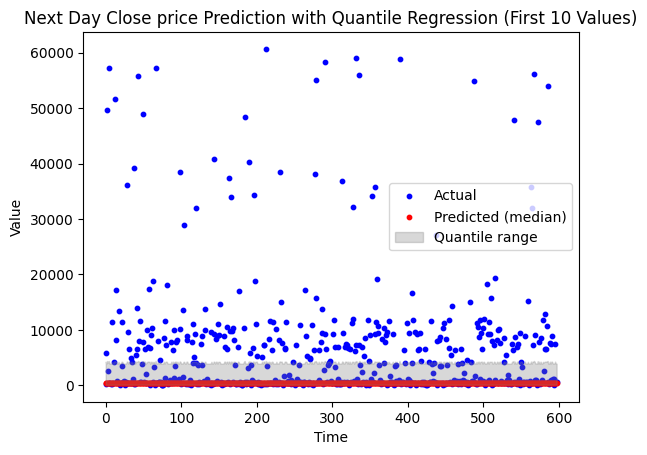

In [6]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = quantile_loss(y_test_pred, y_test, quantiles) # calculate test loss by comparing predicted values vs actual values
    print(f'Test Loss: {test_loss.item():.4f}')
    print(y_test_pred)
    print(y_test)

y_test_inv = scaler_target.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()
y_test_pred_inv = scaler_target.inverse_transform(y_test_pred.numpy()).reshape(-1, num_quantiles)

y_test_inv_10 = y_test_inv
y_test_pred_inv_10 = y_test_pred_inv

plt.scatter(range(len(y_test_inv_10)), y_test_inv_10, label='Actual', color='blue', s=10)
plt.scatter(range(len(y_test_pred_inv_10)), y_test_pred_inv_10[:, 1], label='Predicted (median)', color='red', s=10)
plt.fill_between(range(len(y_test_pred_inv_10)), y_test_pred_inv_10[:, 0], y_test_pred_inv_10[:, 2], color='gray', alpha=0.3, label='Quantile range')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Next Day Close price Prediction with Quantile Regression (First 10 Values)')
plt.legend()
plt.show()


In [7]:
yt = y_test.tolist()
yp = y_test_pred.tolist()
''' I tried to create a dataframe so that we can visualise which quantile each value
falls into, if it says Q6 that means it is above the 5th quartile, note that the data
is normalised so the price isn't the price from the raw data
'''
df = pd.DataFrame(yp, columns=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
df['Actual Close price'] = yt

def determine_quantile(row):
    for i, quantile in enumerate(row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']], 1):
        if row['Actual Close price'] <= quantile:
            return f'Q{i}'
    return f'Q{len(row[["Q1", "Q2", "Q3", "Q4", "Q5"]]) + 1}'

df['Quantile'] = df.apply(determine_quantile, axis=1)

print(df)

           Q1        Q2        Q3        Q4        Q5  Actual Close price  \
0    0.000950  0.005267  0.066350  0.138791  0.565958            0.089614   
1    0.000701  0.004903  0.060540  0.138886  0.565687            0.002481   
2    0.000753  0.005610  0.068170  0.145819  0.640713            0.782484   
3    0.000845  0.005112  0.063768  0.138777  0.565779            0.039511   
4    0.000737  0.005678  0.068329  0.145891  0.653652            0.900636   
..        ...       ...       ...       ...       ...                 ...   
593  0.000707  0.004909  0.060568  0.138752  0.565619            0.016726   
594  0.000701  0.004903  0.060542  0.138899  0.565697            0.000679   
595  0.000958  0.005276  0.066396  0.138701  0.565880            0.117335   
596  0.000703  0.004905  0.060540  0.138840  0.565658            0.008325   
597  0.000703  0.004905  0.060540  0.138837  0.565656            0.008091   

    Quantile  
0         Q4  
1         Q2  
2         Q6  
3         Q3  
